In [1]:
import scipy.cluster.hierarchy as sch
import pandas as pd
from scgenome import cncluster
from scgenome import cnplot, utils
import numpy as np
import matplotlib.pyplot as plt
from scgenome.tests.constants_test import E3_CN_DATA as cnd
import numpy as np

Reading in /Users/massoudmaher/data/clean_sc_1935_1936_1937_cn_data_qc.csv
Doing BHC on 20 cells
4.214630126953125s for BHC on 20 cells
homogeneity: 1.0000000000000004, completeness: 0.7689800970425043, v-measure: 0.8694050298566222


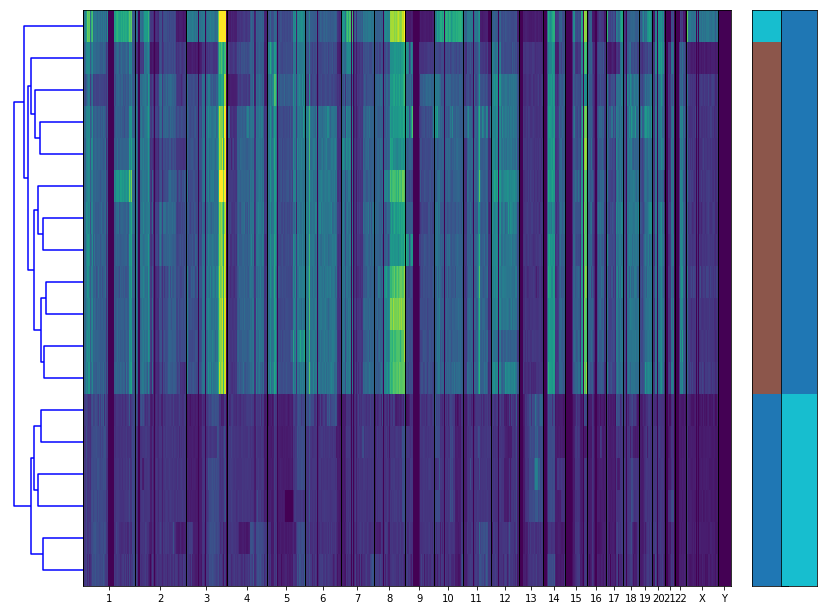

In [2]:
# Do BHC on a spike in experiment
import pandas as pd
import numpy as np
from scgenome import cncluster, utils, simulation, cnplot
import scipy.cluster.hierarchy as sch
import os
import time
import matplotlib.pyplot as plt
import sklearn.metrics as skm


OUT_DIR = "/Users/massoudmaher/data/test_do_bhc/"
CN_DATA_FP = "/Users/massoudmaher/data/clean_sc_1935_1936_1937_cn_data_qc.csv"
SAMPLE_IDS = ['SC-1935', 'SC-1935', 'SC-1937']
N_CELLS = 20  # Set to None if we want all cells
PROPORTIONS = None  # Set to None for equal proportion of each sample
N_STATES = 12
ALPHA = 10
PROB_CN_CHANGE = 0.8

if not os.path.exists(CN_DATA_FP):
    print(f"{CN_DATA_FP} does not exist, creating it")
    os.makedirs(CN_DATA_FP)

print(f"Reading in {CN_DATA_FP}")
cn_data = pd.read_csv(CN_DATA_FP)

if N_CELLS is not None:
    cn_data = utils.get_cn_data_submixture(cn_data, N_CELLS, SAMPLE_IDS,
                                           proportions=PROPORTIONS)

print(f"Doing BHC on {N_CELLS} cells")

start = time.time()
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(cn_data, n_states=N_STATES, alpha=ALPHA,
                               prob_cn_change=PROB_CN_CHANGE)
)
print(f"{time.time()-start}s for BHC on {N_CELLS} cells")

bhc_linkage.to_csv(os.path.join(OUT_DIR, "linkage.csv"))
bhc_cell_ids.to_csv(os.path.join(OUT_DIR, "cell_ids.csv"), header=False)
matrix_data.to_csv(os.path.join(OUT_DIR, "matrix_data.csv"))
np.savetxt(os.path.join(OUT_DIR, "measurement.txt"), measurement)
np.savetxt(os.path.join(OUT_DIR, "variances.txt"), variances)

################ Plotting
bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:, 2] = np.log(bhc_plot_data[:, 2])

bhc_clusters = sch.fcluster(lbhc_plot_data, 12, criterion="distance")
assert len(set(bhc_clusters)) > 1
cn_data = cncluster.prune_cluster(bhc_clusters, bhc_cell_ids, cn_data)

fig = plt.figure(figsize=(10, 8))
bimatrix_data, ps = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int", raw=True,
    flip=True, cell_id_order=bhc_cell_ids)
plt.savefig(os.path.join(OUT_DIR, "heatmap.pdf"))

################## Metrics
clabels = utils.get_mixture_labels(cn_data)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"],
                                                clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, "
      f"v-measure: {scores[2]}")



In [8]:
display(utils.plot_get_mat(cnd))
display(utils.cn_data_to_mat_data_ids(cnd)[0])

cell_id         c1 c2 c3 c4 c5 c6
bhc_cluster_id   0  0  1  1  2  2
chr_index start                  
0         0      1  2  3  4  5  6
          2      1  2  3  4  5  6
          4      1  2  3  4  5  6
          6      1  2  3  4  5  6
1         0      2  3  4  5  6  7
          2      2  3  4  5  6  7
          4      2  3  4  5  6  7
          6      2  3  4  5  6  7

reads                state                copy               
cell_id      c1 c2 c3 c4 c5 c6    c1 c2 c3 c4 c5 c6   c1 c2 c3 c4 c5 c6
chr start                                                              
1   0         1  2  3  4  5  6     1  2  3  4  5  6    1  2  3  4  5  6
    2         1  2  3  4  5  6     1  2  3  4  5  6    1  2  3  4  5  6
    4         1  2  3  4  5  6     1  2  3  4  5  6    1  2  3  4  5  6
    6         1  2  3  4  5  6     1  2  3  4  5  6    1  2  3  4  5  6
2   0         1  2  3  4  5  6     2  3  4  5  6  7    1  2  3  4  5  6
    2         1  2  3  4  5  6     2  3  4  5  6  7    1  2  3  4  5  6
    4         1  2  3  4  5  6     2  3  4  5  6  7    1  2  3  4  5  6
    6         1  2  3  4  5  6     2  3  4  5  6  7    1  2  3  4  5  6

plot_data1
cell_id         c1 c2 c3 c4 c5
bhc_cluster_id   0  0  1  1  2
origin_id_int    1  3  2  2  4
chr_index start               
0         0      1  2  3  4  5
          2      1  2  3  4  5
          4      1  2  3  4  5
          6      1  2  3  4  5
1         0      2  3  4  5  6
          2      2  3  4  5  6
          4      2  3  4  5  6
          6      2  3  4  5  6
ordering
cell_id  bhc_cluster_id  origin_id_int
c1       0               1                3
c2       0               3                2
c3       1               2                1
c4       1               2                0
c5       2               4                4
Name: cell_order, dtype: int64
plot_data2
cell_id         c1 c2 c3 c4 c5
bhc_cluster_id   0  0  1  1  2
origin_id_int    1  3  2  2  4
cell_order       3  2  1  0  4
chr_index start               
0         0      1  2  3  4  5
          2      1  2  3  4  5
          4      1  2  3  4  5
          6      1  2  3  4  5
1         0      2  3  4  5 

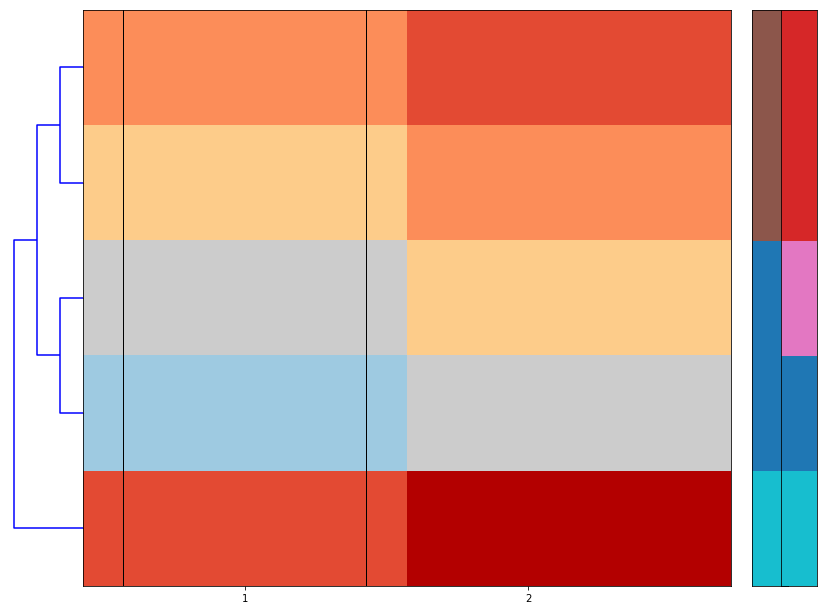

In [15]:
measurement = np.array([
    [1,1,1,1],
    [2,2,2,2],
    [3,3,3,3],
    [4,4,4,4],
    [5,5,5,5],
])

linkage = np.array([
    [0,1,1,2], # 5
    [2,3,1,2], # 6
    [5,6,2,4], # 7
    [4,7,3,5]  # 8
], dtype="float")

cn_data = pd.DataFrame(
    data=[
        #chr start end reads gc  copy state cell_id sample_id library_id origin_id origin_id_int, bhc_cluster_id
        ["1",  0,    1,  1,    -1, 1, 1,    "c1",   "s",      "l",       "o1",     1,             0],
        ["1",  2,    3,  1,    -1, 1, 1,    "c1",   "s",      "l",       "o1",     1,             0],
        ["1",  4,    5,  1,    -1, 1, 1,    "c1",   "s",      "l",       "o1",     1,             0],
        ["1",  6,    7,  1,    -1, 1, 1,    "c1",   "s",      "l",       "o1",     1,             0],
        ["2",  0,    1,  1,    -1, 1, 2,    "c1",   "s",      "l",       "o1",     1,             0],
        ["2",  2,    3,  1,    -1, 1, 2,    "c1",   "s",      "l",       "o1",     1,             0],
        ["2",  4,    5,  1,    -1, 1, 2,    "c1",   "s",      "l",       "o1",     1,             0],
        ["2",  6,    7,  1,    -1, 1, 2,    "c1",   "s",      "l",       "o1",     1,             0],
        
        ["1",  0,    1,  2,    -2, 2, 2,    "c2",   "s",      "l",       "o1",     3,             0],
        ["1",  2,    3,  2,    -2, 2, 2,    "c2",   "s",      "l",       "o1",     3,             0],
        ["1",  4,    5,  2,    -2, 2, 2,    "c2",   "s",      "l",       "o1",     3,             0],
        ["1",  6,    7,  2,    -2, 2, 2,    "c2",   "s",      "l",       "o1",     3,             0],
        ["2",  0,    1,  2,    -2, 2, 3,    "c2",   "s",      "l",       "o1",     3,             0],
        ["2",  2,    3,  2,    -2, 2, 3,    "c2",   "s",      "l",       "o1",     3,             0],
        ["2",  4,    5,  2,    -2, 2, 3,    "c2",   "s",      "l",       "o1",     3,             0],
        ["2",  6,    7,  2,    -2, 2, 3,    "c2",   "s",      "l",       "o1",     3,             0],
       
        ["1",  0,    1,  3,    -3, 3, 3,    "c3",   "s",      "l",       "o2",     2,             1],
        ["1",  2,    3,  3,    -3, 3, 3,    "c3",   "s",      "l",       "o2",     2,             1],
        ["1",  4,    5,  3,    -3, 3, 3,    "c3",   "s",      "l",       "o2",     2,             1],
        ["1",  6,    7,  3,    -3, 3, 3,    "c3",   "s",      "l",       "o2",     2,             1],
        ["2",  0,    1,  3,    -3, 3, 4,    "c3",   "s",      "l",       "o2",     2,             1],
        ["2",  2,    3,  3,    -3, 3, 4,    "c3",   "s",      "l",       "o2",     2,             1],
        ["2",  4,    5,  3,    -3, 3, 4,    "c3",   "s",      "l",       "o2",     2,             1],
        ["2",  6,    7,  3,    -3, 3, 4,    "c3",   "s",      "l",       "o2",     2,             1],
       
        ["1",  0,    1,  4,    -4, 4, 4,    "c4",   "s",      "l",       "o2",     2,             1],
        ["1",  2,    3,  4,    -4, 4, 4,    "c4",   "s",      "l",       "o2",     2,             1],
        ["1",  4,    5,  4,    -4, 4, 4,    "c4",   "s",      "l",       "o2",     2,             1],
        ["1",  6,    7,  4,    -4, 4, 4,    "c4",   "s",      "l",       "o2",     2,             1],
        ["2",  0,    1,  4,    -4, 4, 5,    "c4",   "s",      "l",       "o2",     2,             1],
        ["2",  2,    3,  4,    -4, 4, 5,    "c4",   "s",      "l",       "o2",     2,             1],
        ["2",  4,    5,  4,    -4, 4, 5,    "c4",   "s",      "l",       "o2",     2,             1],
        ["2",  6,    7,  4,    -4, 4, 5,    "c4",   "s",      "l",       "o2",     2,             1],
        
        ["1",  0,    1,  5,    -5, 5, 5,    "c5",   "s",      "l",       "o4",     4,             2],
        ["1",  2,    3,  5,    -5, 5, 5,    "c5",   "s",      "l",       "o4",     4,             2],
        ["1",  4,    5,  5,    -5, 5, 5,    "c5",   "s",      "l",       "o4",     4,             2],
        ["1",  6,    7,  5,    -5, 5, 5,    "c5",   "s",      "l",       "o4",     4,             2],
        ["2",  0,    1,  5,    -5, 5, 6,    "c5",   "s",      "l",       "o4",     4,             2],
        ["2",  2,    3,  5,    -5, 5, 6,    "c5",   "s",      "l",       "o4",     4,             2],
        ["2",  4,    5,  5,    -5, 5, 6,    "c5",   "s",      "l",       "o4",     4,             2],
        ["2",  6,    7,  5,    -5, 5, 6,    "c5",   "s",      "l",       "o4",     4,             2],
        
    ],
    columns=['chr', 'start', 'end', 'reads', 'gc', 'copy', 'state', 'cell_id',
             'sample_id', 'library_id', 'origin_id', 'origin_id_int', 'bhc_cluster_id']
)

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cn_data, "state", cluster_field_name="bhc_cluster_id",
    linkage=linkage, origin_field_name="origin_id_int", max_cn=8)
leaves = sch.dendrogram(linkage, orientation="left", no_plot=True)["leaves"]
cell_ids = ["c1","c2","c3","c4","c5"]
print([cell_ids[i] for i in leaves])

In [5]:
bimatrix_data.T.values

array([[1., 1., 1., 1., 0., 0., 0., 0.],
       [2., 2., 2., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 3., 3., 3., 3.],
       [0., 0., 0., 0., 4., 4., 4., 4.]])

In [2]:
bhc_cell_ids = np.array(['SA1090-A96213A-R24-C42', 'SA1090-A96213A-R28-C55',
       'SA1090-A96213A-R31-C08', 'SA1090-A96213A-R32-C65',
       'SA1090-A96213A-R32-C67', 'SA1090-A96213A-R33-C34',
       'SA1090-A96213A-R34-C20', 'SA1090-A96213A-R35-C45',
       'SA921-A90554A-R04-C64', 'SA921-A90554A-R09-C14',
       'SA921-A90554A-R11-C56', 'SA921-A90554A-R12-C24',
       'SA921-A90554A-R13-C20', 'SA921-A90554A-R13-C44',
       'SA922-A90554B-R24-C17', 'SA922-A90554B-R26-C70',
       'SA922-A90554B-R27-C58', 'SA922-A90554B-R29-C26',
       'SA922-A90554B-R30-C65', 'SA922-A90554B-R35-C14'], dtype=object)

mixed_cn_data = pd.read_csv("/Users/massoudmaher/data/err1_mixed_cn_data.csv")
mixed_cn_data = mixed_cn_data.iloc[:,1:]
lbhc_plot_data = np.loadtxt("/Users/massoudmaher/data/err_lbhc_plot_data.txt")

In [4]:
mixed_cn_data.columns

Index(['chr', 'start', 'end', 'reads', 'gc', 'copy', 'state', 'cell_id',
       'sample_id', 'library_id', 'origin_id', 'origin_id_int'],
      dtype='object')

In [19]:
d1 = cmixed_cn_data1.iloc[np.r_[1:3,400:403,900:903],:]
d2 = cmixed_cn_data2.iloc[np.r_[1:3,500:503,900:903],:]

columns = ['start', 'cell_id', "bhc_cluster_id", "origin_id_int"]
levels = ['cell_id', "bhc_cluster_id", "origin_id_int"]
pd1 = d1.set_index(columns)["state"].unstack(level=levels).fillna(0)
pd2 = d2.set_index(columns)["state"].unstack(level=levels).fillna(0)

print(pd2.index)
print(pd2.columns.levels)
print(pd2.columns.codes)
print(pd2.columns.names)
display(pd2)
display(pd2.sort_index(axis=1, level=[1,2]))
display(pd2.sort_index(axis=1, level=[0]))
display(pd2.sort_index(axis=1, level=[1]))
display(pd2.sort_index(axis=1, level=[2]))
#display(pd2.sort_index(axis=1, level=[3]))

Int64Index([500001, 1000001, 94500001, 95000001, 95500001, 139000001,
            139500001, 140000001],
           dtype='int64', name='start')
[['SA922-A90554B-R24-C17', 'SA922-A90554B-R27-C58', 'SA922-A90554B-R35-C14'], [2], [0]]
[[2, 0, 1], [0, 0, 0], [0, 0, 0]]
['cell_id', 'bhc_cluster_id', 'origin_id_int']


cell_id,SA922-A90554B-R35-C14,SA922-A90554B-R24-C17,SA922-A90554B-R27-C58
bhc_cluster_id,2,2,2
origin_id_int,0,0,0
start,,,
500001,3.0,0.0,0.0
1000001,3.0,0.0,0.0
94500001,0.0,2.0,0.0
95000001,0.0,2.0,0.0
95500001,0.0,2.0,0.0
139000001,0.0,0.0,2.0
139500001,0.0,0.0,2.0


cell_id,SA922-A90554B-R24-C17,SA922-A90554B-R27-C58,SA922-A90554B-R35-C14
bhc_cluster_id,2,2,2
origin_id_int,0,0,0
start,,,
500001,0.0,0.0,3.0
1000001,0.0,0.0,3.0
94500001,2.0,0.0,0.0
95000001,2.0,0.0,0.0
95500001,2.0,0.0,0.0
139000001,0.0,2.0,0.0
139500001,0.0,2.0,0.0


cell_id,SA922-A90554B-R24-C17,SA922-A90554B-R27-C58,SA922-A90554B-R35-C14
bhc_cluster_id,2,2,2
origin_id_int,0,0,0
start,,,
500001,0.0,0.0,3.0
1000001,0.0,0.0,3.0
94500001,2.0,0.0,0.0
95000001,2.0,0.0,0.0
95500001,2.0,0.0,0.0
139000001,0.0,2.0,0.0
139500001,0.0,2.0,0.0


cell_id,SA922-A90554B-R24-C17,SA922-A90554B-R27-C58,SA922-A90554B-R35-C14
bhc_cluster_id,2,2,2
origin_id_int,0,0,0
start,,,
500001,0.0,0.0,3.0
1000001,0.0,0.0,3.0
94500001,2.0,0.0,0.0
95000001,2.0,0.0,0.0
95500001,2.0,0.0,0.0
139000001,0.0,2.0,0.0
139500001,0.0,2.0,0.0


cell_id,SA922-A90554B-R24-C17,SA922-A90554B-R27-C58,SA922-A90554B-R35-C14
bhc_cluster_id,2,2,2
origin_id_int,0,0,0
start,,,
500001,0.0,0.0,3.0
1000001,0.0,0.0,3.0
94500001,2.0,0.0,0.0
95000001,2.0,0.0,0.0
95500001,2.0,0.0,0.0
139000001,0.0,2.0,0.0
139500001,0.0,2.0,0.0


In [34]:
print(pd2.columns.get_values())
print(pd2.columns.get_level_values(0))
print(pd2.columns.get_level_values(1))
print(pd2.columns.get_level_values())

[('SA922-A90554B-R35-C14', 2, 0) ('SA922-A90554B-R24-C17', 2, 0)
 ('SA922-A90554B-R27-C58', 2, 0)]
Index(['SA922-A90554B-R35-C14', 'SA922-A90554B-R24-C17',
       'SA922-A90554B-R27-C58'],
      dtype='object', name='cell_id')
Int64Index([2, 2, 2], dtype='int64', name='bhc_cluster_id')
Int64Index([0, 0, 0], dtype='int64', name='origin_id_int')


ordering
[19 18 13 10 14 12  6 16 11 15  9  8 17  3  7  4  5  1  2  0]
plot_data.index.names
['chr_index', 'start']
plot_data.columns.names
['cell_id', 'bhc_cluster_id', 'origin_id_int']
plot_data.index.names
['chr_index', 'start']
plot_data.columns.names
['cell_id', 'bhc_cluster_id', 'origin_id_int', 'cell_order']
----------------



ordering
[19 18 13 10 14 12  6 16 11 15  9  8 17  3  7  4  5  1  2  0]
plot_data.index.names
['chr_index', 'start']
plot_data.columns.names
['cell_id', 'bhc_cluster_id', 'origin_id_int']
plot_data.index.names
['chr_index', 'start']
plot_data.columns.names
['cell_id', 'bhc_cluster_id', 'origin_id_int', 'cell_order']
ordering
[19 18 13 10 14 12  6 16 11 15  9  8 17  3  7  4  5  1  2  0]
plot_data.index.names
['chr_index', 'start']
plot_data.columns.names
['cell_id', 'bhc_cluster_id', 'origin_id_int']
plot_data.index.names
['chr_index', 'start']
plot_data.columns.names
['cell_id', 'bhc_cluster_id', 'origin_id_int', 'cell_order']
ordering
[19 18 13 10 14 12  

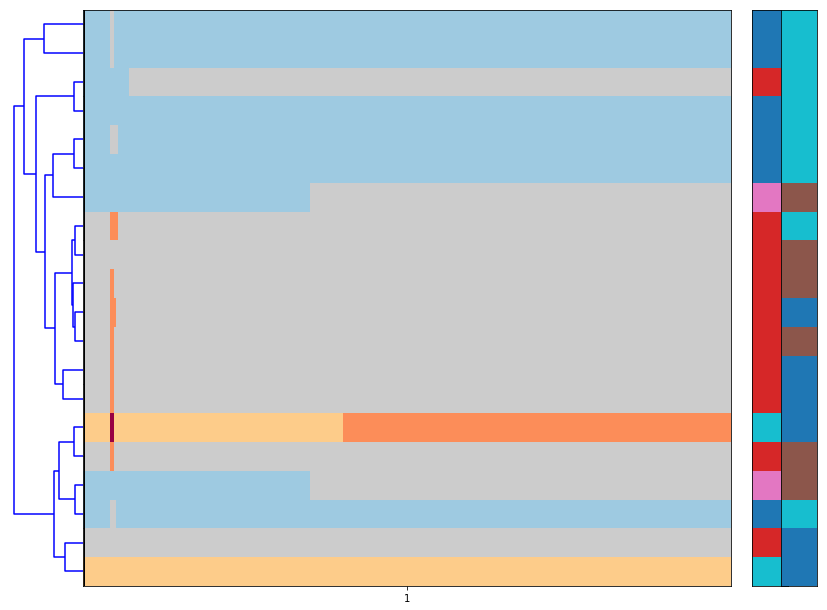

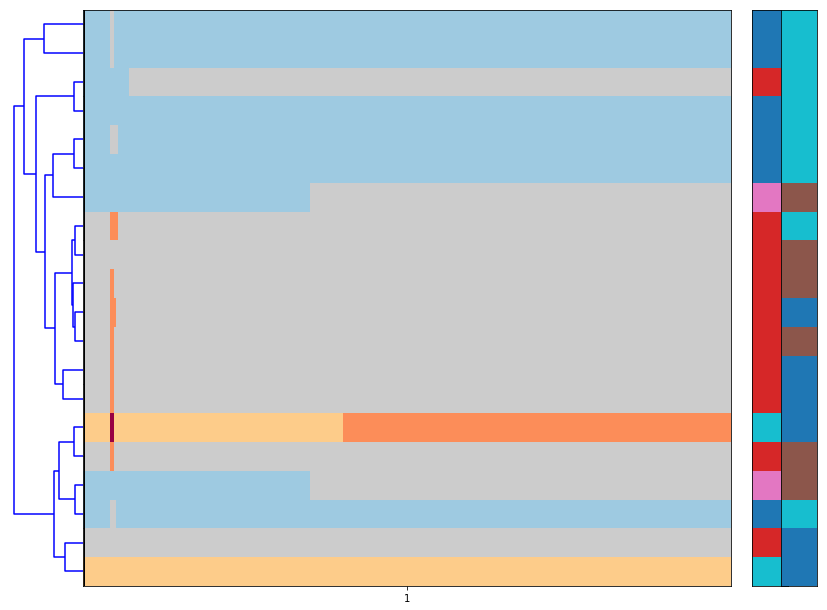

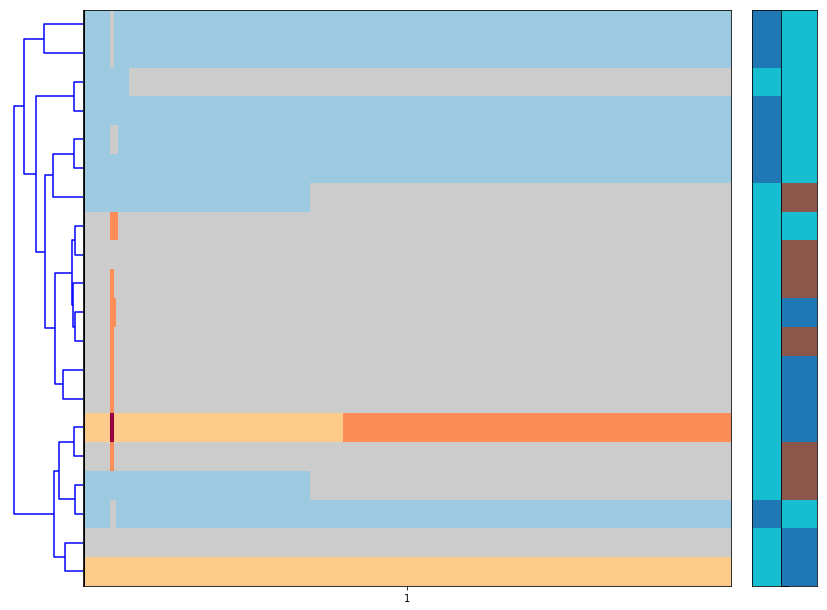

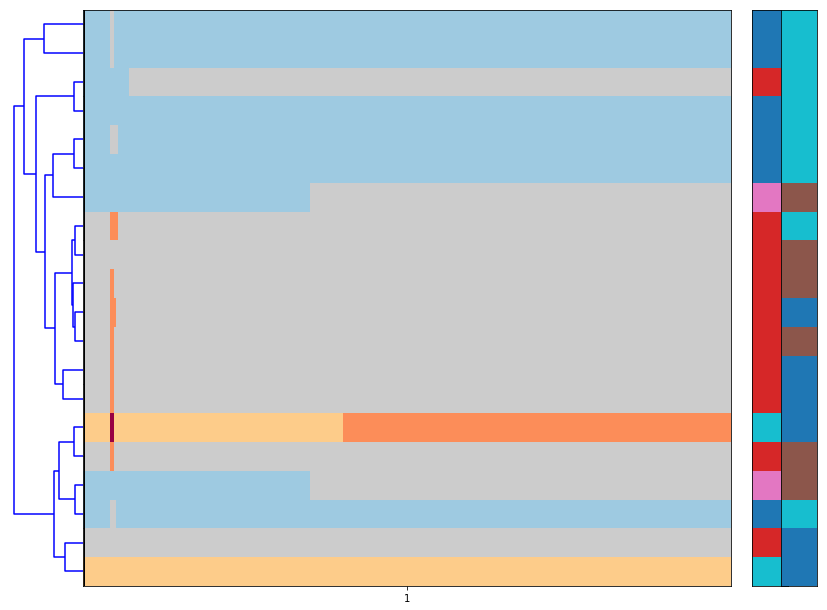

In [3]:
clustering = sch.fcluster(lbhc_plot_data, 7, criterion="distance")
cmixed_cn_data1 = cncluster.prune_cluster(clustering, bhc_cell_ids, mixed_cn_data)

fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cmixed_cn_data1, "state", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int")
print("----------------\n\n\n")
clustering = sch.fcluster(lbhc_plot_data, 10, criterion="distance")
cmixed_cn_data2 = cncluster.prune_cluster(clustering, bhc_cell_ids, mixed_cn_data)

fig = plt.figure(figsize=(10, 8))
bimatrix_data1 = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cmixed_cn_data1, "state", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int")

fig = plt.figure(figsize=(10, 8))
bimatrix_data2 = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cmixed_cn_data2, "state", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int")

clustering = sch.fcluster(lbhc_plot_data, 7, criterion="distance")
cmixed_cn_data3 = cncluster.prune_cluster(clustering, bhc_cell_ids, mixed_cn_data)
fig = plt.figure(figsize=(10, 8))
bimatrix_data = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, cmixed_cn_data3, "state", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int")

In [5]:
mixed_cn_data = pd.read_csv("/Users/massoudmaher/data/err_mixed_cn_data.csv")

# bhc params
n_states = 12
alpha = 0.3
prob_cn_change = 0.8

bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
    cncluster.bayesian_cluster(mixed_cn_data, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change, debug=True)
)

In [4]:
pd.set_option('display.max_rows',100)
display(bhc_linkage)

,i,j,r_merge,naive_dist,log_like,i_count,j_count,pi,d,result_ind,d_left,d_right,ll_left,ll_right,pi_left,pi_right,tree_ll,tree_ll_left,tree_ll_right,merge_count
0,22,27,-469.981,9.48683,7410.57,1,1,-1.95639,0.752415,100,0.3,0.3,1,1,1,1,7878.6,2123.3,5753.33,2
1,41,51,-923.385,9.84886,1455.6,1,1,-1.95639,0.752415,101,0.3,0.3,1,1,1,1,2377.03,1084.49,1290.58,2
2,47,53,-963.55,12,2644,1,1,-1.95639,0.752415,102,0.3,0.3,1,1,1,1,3605.6,2132.05,1471.59,2
3,59,64,-988.537,13,1952.9,1,1,-1.95639,0.752415,103,0.3,0.3,1,1,1,1,2939.48,2063.59,873.929,2
4,1,100,-1040.53,7.34847,11597.9,1,2,-1.75341,1.24259,104,0.3,0.752415,1,7410.57,1,-1.95639,12636.6,4756.3,7878.6,3
5,44,61,-1060.41,13.3041,1750.05,1,1,-1.95639,0.752415,105,0.3,0.3,1,1,1,1,2808.51,1155.23,1651.32,2
6,8,37,-1078.56,14.1421,6429.56,1,1,-1.95639,0.752415,106,0.3,0.3,1,1,1,1,7506.17,5167.57,2336.64,2
7,40,69,-1117.52,10.8628,1599.14,1,1,-1.95639,0.752415,107,0.3,0.3,1,1,1,1,2714.71,1575.79,1136.96,2
8,72,96,-1410.49,14.5602,172.393,1,1,-1.95639,0.752415,108,0.3,0.3,1,1,1,1,1580.93,963.593,615.377,2
9,52,66,-1479.86,16.7033,56.6392,1,1,-1.95639,0.752415,109,0.3,0.3,1,1,1,1,1534.54,880.075,652.509,2


In [3]:
from scgenome import tantalus

total_ncells = 100
hmmcopy_tickets = ['SC-1936', 'SC-1937']
sample_ids = [['SA921'], ['SA1090']]

#def spike_in(num_cells, hmmcopy_tickets, sample_ids, cached=False,
#             local_cache_directory=get_local_cache_dir(), proportions=None,
#             id_field_name=CELL_ID, origin_field_name=ORIGIN_ID, seed=None):

results = tantalus.spike_in(total_ncells, hmmcopy_tickets, sample_ids, cached=True)

NotFoundError: no object for analysis, {'analysis_type__name': 'hmmcopy', 'jira_ticket': 'S'}

cn_data
  chr  bin    cell_id  state  start  end cluster_id      copy
0   1    0  cl1_cell0      2      0    9        cl1  2.943771
1   1    1  cl1_cell0      3     10   19        cl1  3.561983
2   1    2  cl1_cell0      3     20   29        cl1  3.435017
3   1    3  cl1_cell0      3     30   39        cl1  3.055985
4   1    4  cl1_cell0      1     40   49        cl1  1.438367


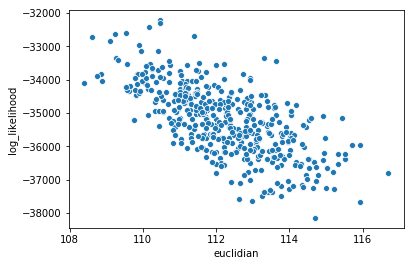

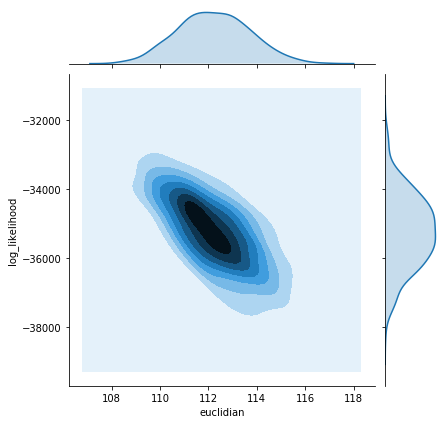

In [19]:
from scgenome import utils
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import numpy as np
from scgenome.jointcnmodels import get_variances, get_tr_probs, calculate_marginal_ll_simple
from scipy import special
import seaborn as sns
import pandas as pd

n_cell = 30
n_bin = 3000

cn_mat = np.concatenate([1+np.random.poisson(lam=2, size=n_bin)[np.newaxis,:] for i in range(n_cell)])
n_states = cn_mat.max()
cell_ids = [f"cl1_cell{i}" for i in range(n_cell)]
chr_names = ["1", "2"]
df_cn_mat = utils.cn_mat_as_df(cn_mat, chr_names)
#print(f"df_cn_mat \n {df_cn_mat}")

cn_data = utils.cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_", expand=True).iloc[:, 0]
cn_data["state"] = cn_data["copy"] + abs(np.random.normal(scale=0.5,size=cn_data.shape[0]))
cn_data.columns = ["chr","bin","cell_id","state","start","end","cluster_id","copy"]

matrix_data, measurement, cell_ids = utils.cn_data_to_mat_data_ids(cn_data, value_ids=["copy"])
#matrix_data2 = (
#    cn_data
#        .merge(pd.DataFrame({'cell_id': cell_ids}))
#        .set_index(['chr', 'start', 'cell_id'])[['state', 'copy']]
#        .unstack(level=2, fill_value=0.))

print("cn_data")
print(cn_data.head())
old_variances = get_variances(cn_data, matrix_data, n_states)
cell_state_var = cn_data[['cell_id', 'state', 'copy']].dropna() \
                    .groupby(['cell_id', 'state'])['copy'] \
                    .var().rename('copy_var') \
                    .reset_index()
#print("cell_state_var")
#print(cell_state_var)
    
variances = cell_state_var.set_index(["state",'cell_id'])['copy_var'].unstack()
#print(variances.head())
#print(variances.shape)
variances = variances.reindex(columns=cell_ids, index=range(n_states)).fillna(0.05).T
variances = variances.values

variances[variances < 0.001] = 0.001

#variances = get_variances(cn_data, matrix_data, n_state)

trans_model = {"kind":"twoparam", "e0": 0.9, "e1": 0.1}

pw_euc = squareform(pdist(measurement))

pw_ll = np.zeros((n_cell, n_cell))
for i,j in combinations(range(n_cell), 2):
    pw_ll[i, j] = calculate_marginal_ll_simple(measurement[[i,j], :], old_variances[[i,j], :], trans_model)
    
#print(f"pw_euc \n{pw_euc}")
#print(f"pw_ll \n{pw_ll}")
#print(f"cn_mat \n{cn_mat}")
#print(f"cn_data \n{cn_data}")

pwd = pd.DataFrame({"euclidian" : pw_euc[np.triu_indices(n_cell,1)],
                    "log_likelihood" : pw_ll[np.triu_indices(n_cell,1)]})
sns.scatterplot(data=pwd, x="euclidian", y="log_likelihood")
sns.jointplot(data=pwd, x="euclidian", y="log_likelihood", kind="kde")

In [14]:
cn_data["reads"] = 1
display(cn_data.head())

def conv(cn_data, index_ids = ["chr","start","cell_id"], value_ids=["reads","state","copy"]):
    matrix_data = (
        cn_data.set_index(index_ids)[value_ids]
            .unstack(level=2, fill_value=0.))
    copy = matrix_data["copy"].values
    measurement = copy.T

    cell_ids = matrix_data["copy"].columns
    return matrix_data, measurement, cell_ids

def cn_data_to_mat_data_ids(cn_data, data_id=CN_DATA_ID, cell_id=CELL_ID,
                            index_ids=INDEX_IDS, value_ids=VALUE_IDS):
    matrix_data = (
        cn_data.set_index(index_ids)[value_ids]
            .unstack(level=2, fill_value=0.))
    copy = matrix_data[data_id].values
    measurement = copy.T

    cell_ids = matrix_data.columns.to_frame().loc[data_id][cell_id]
    return matrix_data, measurement, cell_ids

res = conv(cn_data)
display(res[0])
display(res[1])
display(res[1].shape)
display(cn_mat)
display(res[2])
display(res[2].shape)

,chr,bin,cell_id,state,start,end,cluster_id,copy,reads
0,1,0,cl1_cell0,2,0,9,cl1,2.384862,1
1,1,1,cl1_cell0,3,10,19,cl1,3.213635,1
2,1,2,cl1_cell0,4,20,29,cl1,4.715666,1
3,1,3,cl1_cell0,2,30,39,cl1,2.115816,1
4,1,4,cl1_cell0,4,40,49,cl1,4.064646,1


reads                                                        \
cell_id   cl1_cell0 cl1_cell1 cl1_cell10 cl1_cell11 cl1_cell12 cl1_cell13   
chr start                                                                   
1   0             1         1          1          1          1          1   
    10            1         1          1          1          1          1   
    20            1         1          1          1          1          1   
    30            1         1          1          1          1          1   
    40            1         1          1          1          1          1   
    50            1         1          1          1          1          1   
    60            1         1          1          1          1          1   
    70            1         1          1          1          1          1   
    80            1         1          1          1          1          1   
    90            1         1          1          1          1          1   
    100           1         1          1          1          1          1   
    110           1         1          1          1          1          1   
    120           1         1          1          1          1          1   
    130           1         1          1          1          1          1   
    140           1         1          1          1          1          1   
    150           1         1          1          1          1          1   
    160           1         1          1          1          1          1   
    170           1         1          1          1          1          1   
    180           1         1          1          1          1          1   
    190           1         1          1          1          1          1   
    200           1         1          1          1          1          1   
    210           1         1          1          1          1          1   
    220           1         1          1          1          1          1   
    230           1         1          1          1          1          1   
    240           1         1          1          1          1          1   
    250           1         1          1          1          1          1   
    260           1         1          1          1          1          1   
    270           1         1          1          1          1          1   
    280           1         1          1          1          1          1   
    290           1         1          1          1          1          1   
...             ...       ...        ...        ...        ...        ...   
2   29700         1         1          1          1          1          1   
    29710         1         1          1          1          1          1   
    29720         1         1          1          1          1          1   
    29730         1         1          1          1          1          1   
    29740         1         1          1          1          1          1   
    29750         1         1          1          1          1          1   
    29760         1         1          1          1          1          1   
    29770         1         1          1          1          1          1   
    29780         1         1          1          1          1          1   
    29790         1         1          1          1          1          1   
    29800         1         1          1          1          1          1   
    29810         1         1          1          1          1          1   
    29820         1         1          1          1          1          1   
    29830         1         1          1          1          1          1   
    29840         1         1          1          1          1          1   
    29850         1         1          1          1          1          1   
    29860         1         1          1          1          1          1   
    29870         1         1          1          1          1          1   
    29880 

array([[2.38486204, 3.2136347 , 4.71566585, ..., 4.25213228, 3.37546152,
        3.3619273 ],
       [1.09308696, 7.84230184, 2.57316445, ..., 2.61318993, 4.89600777,
        3.23400525],
       [3.12443011, 6.23071342, 4.06220525, ..., 2.53490068, 1.28128525,
        3.02896531],
       ...,
       [2.03662685, 2.00202804, 3.20728217, ..., 2.4363144 , 2.63314016,
        5.54094802],
       [2.23690523, 5.12320685, 1.66403486, ..., 3.08132883, 4.48736636,
        2.42344298],
       [4.14832439, 2.22910757, 4.49177588, ..., 4.85064988, 2.25918527,
        2.18313797]])

(30, 3000)

array([[2, 3, 4, ..., 4, 3, 3],
       [1, 7, 2, ..., 2, 4, 3],
       [4, 2, 3, ..., 4, 4, 3],
       ...,
       [3, 3, 3, ..., 1, 3, 3],
       [2, 3, 1, ..., 1, 5, 1],
       [3, 2, 4, ..., 4, 1, 5]])

Index(['cl1_cell0', 'cl1_cell1', 'cl1_cell10', 'cl1_cell11', 'cl1_cell12',
       'cl1_cell13', 'cl1_cell14', 'cl1_cell15', 'cl1_cell16', 'cl1_cell17',
       'cl1_cell18', 'cl1_cell19', 'cl1_cell2', 'cl1_cell20', 'cl1_cell21',
       'cl1_cell22', 'cl1_cell23', 'cl1_cell24', 'cl1_cell25', 'cl1_cell26',
       'cl1_cell27', 'cl1_cell28', 'cl1_cell29', 'cl1_cell3', 'cl1_cell4',
       'cl1_cell5', 'cl1_cell6', 'cl1_cell7', 'cl1_cell8', 'cl1_cell9'],
      dtype='object', name='cell_id')

(30,)

In [20]:
old_variances == variances

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  Tr

In [12]:
pw_euc

array([[ 0.        , 30.98804289, 31.82838566, ..., 32.03855084,
        32.40225677, 32.90686509],
       [30.98804289,  0.        , 31.56414923, ..., 31.2849748 ,
        30.41000579, 31.282114  ],
       [31.82838566, 31.56414923,  0.        , ..., 31.31081775,
        30.54465633, 33.10146208],
       ...,
       [32.03855084, 31.2849748 , 31.31081775, ...,  0.        ,
        32.18035399, 32.74232728],
       [32.40225677, 30.41000579, 30.54465633, ..., 32.18035399,
         0.        , 31.68167703],
       [32.90686509, 31.282114  , 33.10146208, ..., 32.74232728,
        31.68167703,  0.        ]])

In [4]:
bhc_linkage.to_csv("/Users/massoudmaher/data/err_bhc_linkage.csv")